(chap:19-ppp)=
# 一物一価と購買力平価

<div name="html-admonition" style="font-size: 0.8em">
<input type="button" onclick="location.href='https://translate.google.com/translate?hl=&sl=ja&tl=en&u='+window.location;" value="Google translation" style="color:#ffffff;background-color:#008080; height:25px" onmouseover="this.style.background='#99ccff'" onmouseout="this.style.background='#008080'"/> in English or the language of your choice.
</div><br>

In [1]:
import japanize_matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import py4macro
import statsmodels.formula.api as smf

# 警告メッセージを非表示
import warnings
warnings.filterwarnings("ignore")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## はじめに

通常，経済の生活水準の指標には一人当たりGDPが使われる。データはそれぞれの国が集めており，日本では[内閣府](https://www.esri.cao.go.jp/jp/sna/menu.html)がGDP関連のデータを公表している。当たり前だが，GDPなどの変数はその経済の貨幣単位で表される。自国通貨建てのデータは国内で使うには十分だが，他国と比較する場合は共通の貨幣で表す必要がある。例えば，日本と米国の生活水準や政府の教育関連支出額の違いを知るためには，両国のデータを円もしくは米ドルに返還する必要がある。また，変数の水準だけではなく成長率を考える際も同様である。

では，ある通貨を他の通貨単位に換算する際，新聞やインターネットで見る市場為替レートを使えば良いのだろうか。答えは否である。その理由を理解するのが本章の１つの目的となる。異なる経済のデータを比べる際は購買力平価（PPP; Purchasing Power Parity）と呼ばれる「為替レート」を使う必要がある。実際，`py4macro`モジュールに含まれるデータセット`pwt`（Penn World Table）はPPPで換算したマクロデータを使っている。

以下では、まずPPPと関連が深い一物一価の法則について国内のデータを使い考える。その後，経済間のデータとしてビッグマック（マクドナルドのハンバーガー）のデータを使い経済間での一物一価を考察する。また一般物価水準についても考察し，経済間で一般物価水準が異なる要因として所得水準を考え，所得水準の影響が大きいことを明らかにする。特に，所得水準の影響により，市場為替レートを使い計算した一人当たりGDPの比較をおこなうと，経済間の所得格差が歪められることになる。そのような歪みを排除して経済間の生活水準を比べるためには，PPPレートを使う必要があることを示す。

````{note}
私たちの周りには価格が法的に定められたものがある。例えば，

* 鉄道運賃(JR，通学定期，JR西日本，幹線，高校，20km)：38,650円（2023年4月）

この価格は鉄道事業法（昭和６１年法律第９２号）に基づいている。以下では，法律ではなく**市場**によって価格が決まる財・サービスを考える。
````

## 国内での一物一価

### 説明

一物一価の法則とは，市場の働きにより同質財・サービスは同じ価格で販売される，ということを意味する。直感的に説明するために，A市とB市で同質財が販売されているとしよう（A市を１つの市場，B市をもう１つの市場と考えると良いだろう）。話を簡単にするために，輸送費用，取引費用や価格の硬直性など市場の「摩擦」が無い理想的な状況の下，A市では80円で，B市では100円で販売されているとしよう。B市で高値で商品が売れるのであれば，A市で安く購入してB市で80円＜価格＜100円の価格で売れば利潤を得ることができる。例えば，ある企業はA市で財をX個仕入れて，それをB市で販売する場合，利潤$\pi$は次式となる。

$$
\pi=p_BX-p_AX=\left(p_B-p_A\right)X>0
$$ (eq:19-1)

ここで$p_BX$が総収入であり，$p_AX$が総費用である。$p_B<p_A$が成立する限り$\pi>0$となる。一方で，利潤があれば，同様のことをする企業が参入する。この様な裁定取引により，A市での需要が増加し価格が上昇する。一方，B市では供給が増えるので価格は下落する。参入は利潤がなくなるまで続くことになり，最終的には財の価格は収斂することになる。即ち，

$$
\pi=0\quad\Rightarrow\quad
p_B=p_A
$$ (eq:19-2)

このように，一物一価は非常に直感的な概念である。では，データではどのようになっているのだろうか。以下では[小売物価統計調査（動向編）](https://www.stat.go.jp/data/kouri/doukou/index.html)のデータを用いる。使うデータはチョコレート，アイスクリーム，ガソリンの2022年平均価格であり，`pandas`を使って[e-Stat（政府統計の総合窓口）](https://www.e-stat.go.jp/)から直接ダウンロードする。

```{note}
手動でダウンロードする場合は，次の順番でリンクを辿っていけば良いだろう。
* [小売物価統計調査（動向編）](https://www.stat.go.jp/data/kouri/doukou/index.html) → `調査の結果`をクリック → `全品目：平成13年(2001年)～2022年`をクリック → `2022年報`をクリック → `統計表`をクリック → `2022年`をクリック
    * チョコレートとアイスクリームのデータは`【09】「1701 ようかん」 ～ 「1784 ゼリー」`の右側にある`EXCEL`をクリックするとダウンロードできる。
    * ガソリンは`【26】「7691 鉄道運賃」 ～ 「7413 通信料」`の右側にある`EXCEL`をクリックするとダウンロードできる。
```

### チョコレート

> 板チョコレート，50～55g，「明治ミルクチョコレート」，「ロッテガーナミルクチョコレート」又は「森永ミルクチョコレート」

このチョコレートの定義に従って作成されたデータをダウンロードし，変数`choco`に`DateFrame`として割り当てる。

In [2]:
url_choco = 'https://www.e-stat.go.jp/stat-search/file-download?statInfId=000040047298&fileKind=0'
choco = pd.read_excel(url_choco, sheet_name='1761チョコレート',
                      skiprows=15, usecols=[8,10])

```{admonition} 🐍 コードの説明
:class: dropdown
* `pd.read_excel()`はExcelファイルを読み込む関数
    * `url_choco`：その上のURLを文字列としてファイルを指定する引数（URLでなくてもファイル名でも良い）
    * `sheet_name`：Excelのシート名を指定する引数
    * `skiprows`：最初の何行を飛ばして読み込むかを指定する引数
    * `usecols`：何番目の列を読み込むかを指定する引数
* `pd.read_excel()`を使うにはモジュール`openpyxl`が事前にインストールされている必要がある。[参照リンク](https://pypi.org/project/openpyxl/)。
```

最初の５行を表示してみよう。

In [3]:
choco.head()

,地域,年平均
0,札幌市,227
1,函館市,211
2,旭川市,209
3,青森市,220
4,八戸市,225


列ラベルが全角になっている。そのままでも良いが，ここでは次の様に半角に変更する。

In [4]:
choco.columns = ['area', 'price']

次にデータ型や欠損値を調べてみよう。

In [5]:
choco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   area    81 non-null     object
 1   price   81 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


どのような地域が含まれているか確認してみよう。

In [6]:
choco['area'].tolist()

['札幌市',
 '函館市',
 '旭川市',
 '青森市',
 '八戸市',
 '盛岡市',
 '仙台市',
 '秋田市',
 '山形市',
 '福島市',
 '郡山市',
 '水戸市',
 '日立市',
 '宇都宮市',
 '小山市',
 '前橋市',
 'さいたま市',
 '熊谷市',
 '川口市',
 '所沢市',
 '千葉市',
 '佐倉市',
 '浦安市',
 '東京都区部',
 '八王子市',
 '立川市',
 '府中市',
 '横浜市',
 '川崎市',
 '相模原市',
 '横須賀市',
 '新潟市',
 '長岡市',
 '富山市',
 '金沢市',
 '福井市',
 '甲府市',
 '長野市',
 '松本市',
 '岐阜市',
 '静岡市',
 '浜松市',
 '富士市',
 '名古屋市',
 '岡崎市',
 '津市',
 '松阪市',
 '大津市',
 '京都市',
 '大阪市',
 '堺市',
 '枚方市',
 '東大阪市',
 '神戸市',
 '姫路市',
 '西宮市',
 '伊丹市',
 '奈良市',
 '和歌山市',
 '鳥取市',
 '松江市',
 '岡山市',
 '広島市',
 '福山市',
 '山口市',
 '宇部市',
 '徳島市',
 '高松市',
 '松山市',
 '今治市',
 '高知市',
 '福岡市',
 '北九州市',
 '佐賀市',
 '長崎市',
 '佐世保市',
 '熊本市',
 '大分市',
 '宮崎市',
 '鹿児島市',
 '那覇市']

兵庫県からは神戸市，姫路市，西宮市，伊丹市が含まれている。

記述統計も確認しよう。

In [7]:
choco['price'].describe()

count     81.000000
mean     217.604938
std        8.204692
min      192.000000
25%      212.000000
50%      218.000000
75%      223.000000
max      242.000000
Name: price, dtype: float64

In [8]:
from myst_nb import glue
choco_min = int( choco['price'].describe()['min'] )
choco_max = int( choco['price'].describe()['max'] )
choco_diff = choco_max - choco_min
glue("choco_min_glued", choco_min)
glue("choco_max_glued", choco_max)
glue("choco_diff_glued", choco_diff)

192

242

50

最安値は{glue:text}`choco_min_glued`円，最高値は{glue:text}`choco_max_glued`円であり，その差は{glue:text}`choco_diff_glued`円！

価格の分布を調べるために，平均からの乖離率を計算しよう。

$$
\pi_i
=\frac{P_i}{\overline{P}}-1
$$ (eq:19-choco)

ここで$i$は地域を表しており，$\overline{P}$は$P_i$の平均である。新たな列`mean_deviation`として追加しよう。

In [9]:
choco['mean_deviation'] =  choco['price'] / choco['price'].mean() - 1

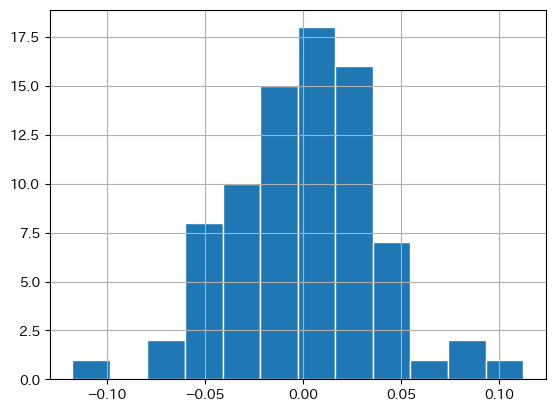

In [10]:
choco['mean_deviation'].hist(bins=12, ec='white')
pass

`0`は平均と等しいという意味である。`0.10`は平均より`10`％高い価格であり，`-0.10`は平均より`10`％安いチョコレートである。明らかに一物一価は成立していない。

価格のばらつき具合を確認するために標準偏差を計算しよう。

In [11]:
choco['mean_deviation'].std()

0.03770453161138014

乖離率[](eq:19-choco)の標準偏差は次式で定義される変動係数（Coefficient of Variation）と等しい。

$$
P_iの変動係数=\frac{P_iの標準偏差}{P_iの平均}
$$ (eq:19-cc)

試しに変動係数を直接計算してみよう。

In [12]:
choco['price'].std() / choco['price'].mean()

0.03770453161138013

同じ値である。変動係数の利点は，変数の平均で除している為，単位（ここでは，円）や平均の大小に関係なく，異なるデータのばらつき具合を比べることができることである。

最後に，チョコレートが最安値の地域はどこか確認してみよう。

In [13]:
cond = ( choco['price']==choco['price'].min() )
choco.loc[cond,:]

,area,price,mean_deviation
7,秋田市,192,-0.117667


In [14]:
from myst_nb import glue
cond = ( choco['price']==choco['price'].min() )
area_min = choco.loc[cond,'area'].iloc[0]
choco_mean_dev = -100*choco.loc[cond,'mean_deviation'].iloc[0]
glue("area_min_glued", area_min)
glue("choco_mean_dev_glued", choco_mean_dev)

'秋田市'

11.766708271871096

{glue:text}`area_min_glued`ではチョコレートが平均よりも約{glue:text}`choco_mean_dev_glued:.1f`％も安い。（甘党の楽園かも！？）

### アイスクリーム

アイスクリームの定義
> バニラアイスクリーム，カップ入り（110mL入り），「ハーゲンダッツ バニラ」

データをダウンロードして，変数`ice`に割り当てよう。

In [15]:
url_ice = 'https://www.e-stat.go.jp/stat-search/file-download?statInfId=000040047298&fileKind=0'
ice = pd.read_excel(url_ice, sheet_name='1782アイスクリーム', 
                    skiprows=15, usecols=[8,10])

最初の５行の表示

In [16]:
ice.head()

,地域,年平均
0,札幌市,296
1,函館市,286
2,旭川市,281
3,青森市,260
4,八戸市,258


列ラベルの変更

In [17]:
ice.columns = ['area', 'price']

データの確認

In [18]:
ice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   area    81 non-null     object
 1   price   81 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


記述統計

In [19]:
ice['price'].describe()

count     81.000000
mean     263.888889
std       18.672172
min      210.000000
25%      258.000000
50%      267.000000
75%      276.000000
max      300.000000
Name: price, dtype: float64

In [20]:
from myst_nb import glue
ice_min = int( ice['price'].describe()['min'] )
ice_max = int( ice['price'].describe()['max'] )
ice_diff = ice_max - ice_min
glue("ice_min_glued", ice_min)
glue("ice_max_glued", ice_max)
glue("ice_diff_glued", ice_diff)

210

300

90

最安値は{glue:text}`ice_min_glued`円，最高値は{glue:text}`ice_max_glued`円であり，その差は{glue:text}`ice_diff_glued`円！（著者のように）ハーゲンダッツ好きにとっては無視できない価格差である。

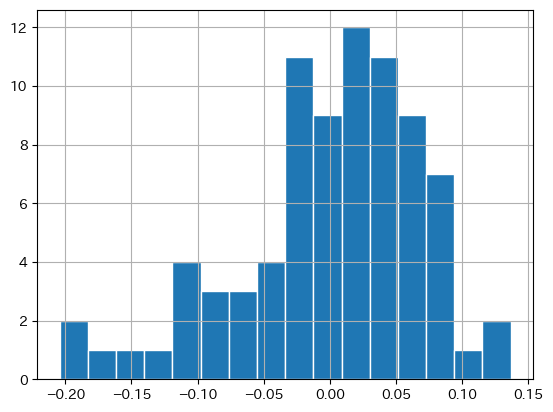

In [21]:
ice['mean_deviation'] =  ice['price'] / ice['price'].mean() - 1

ice['mean_deviation'].hist(bins=16, ec='white')
pass

In [22]:
from myst_nb import glue
cond = ( ice['price']==ice['price'].min() )
ice_mean_dev = -100*ice.loc[cond,'mean_deviation'].iloc[0]
glue('ice_mean_dev_glued',ice_mean_dev)

20.421052631578952

安いところは平均よりも約{glue:text}`ice_mean_dev_glued:.0f`％もお得！いずれにしろ，一物一価は成立していない。

価格のばらつき具合を確認するために標準偏差（変動係数）を計算してみよう。

In [23]:
ice['mean_deviation'].std()

0.0707577036906862

チョコレートと比較すると価格のばらつきが大きい。

安い地域と高い地域を確認してみよう。

In [24]:
ice.sort_values(by='price', ascending=False)

,area,price,mean_deviation
80,那覇市,300,0.136842
0,札幌市,296,0.121684
35,福井市,289,0.095158
60,松江市,288,0.091368
1,函館市,286,0.083789
...,...,...,...
15,前橋市,232,-0.120842
21,佐倉市,223,-0.154947
22,浦安市,216,-0.181474
37,長野市,211,-0.200421


この順番を見て何か言えることがあるだろうか。考えてみよう！

### ガソリン

ガソリンの定義
> レギュラー・ガソリン１L

変数`gas`に`DataFrame`として割り当てよう。

In [25]:
url_gas = 'https://www.e-stat.go.jp/stat-search/file-download?statInfId=000040047335&fileKind=0'
gas = pd.read_excel(url_gas, sheet_name='7301ガソリン', 
                    skiprows=15, usecols=[8,10])

最初の５行の表示

In [26]:
gas.head()

,地域,年平均
0,札幌市,167
1,函館市,167
2,旭川市,169
3,青森市,166
4,八戸市,164


列ラベルの変更

In [27]:
gas.columns = ['area', 'price']

データの詳細

In [28]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   area    81 non-null     object
 1   price   81 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


記述統計

In [29]:
gas['price'].describe()

count     81.000000
mean     170.604938
std        4.718790
min      160.000000
25%      168.000000
50%      170.000000
75%      174.000000
max      184.000000
Name: price, dtype: float64

In [30]:
from myst_nb import glue
gas_min = int( gas['price'].describe()['min'] )
gas_max = int( gas['price'].describe()['max'] )
gas_diff = gas_max - gas_min
glue("gas_min_glued", gas_min)
glue("gas_max_glued", gas_max)
glue("gas_diff_glued", gas_diff)

160

184

24

最安値は{glue:text}`gas_min_glued`円，最高値は{glue:text}`gas_max_glued`円であり，その差は{glue:text}`gas_diff_glued`円。平均からの乖離のヒストグラムをプロットしよう。

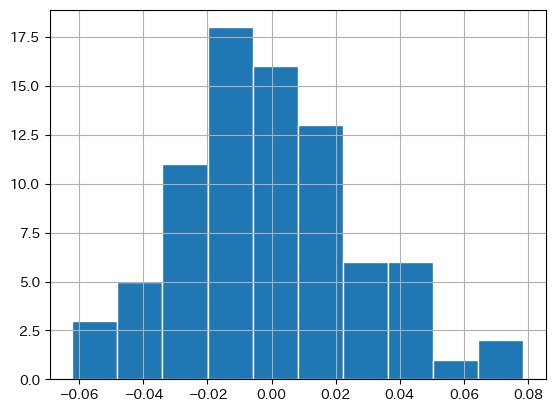

In [31]:
gas['mean_deviation'] = gas['price'] / gas['price'].mean() - 1

gas['mean_deviation'].hist(ec='white')
pass

In [32]:
from myst_nb import glue
cond = ( gas['mean_deviation']==gas['mean_deviation'].min() )
gas_mean_dev_min = -100*gas.loc[cond,'mean_deviation'].iloc[0]
cond = ( gas['mean_deviation']==gas['mean_deviation'].max() )
gas_mean_dev_max = 100*gas.loc[cond,'mean_deviation'].iloc[0]
glue('gas_mean_dev_min_glued',gas_mean_dev_min)
glue('gas_mean_dev_max_glued',gas_mean_dev_max)

6.216079311093425

7.8515087922425675

平均から高くても約{glue:text}`gas_mean_dev_max_glued:.1f`％，安くても約{glue:text}`gas_mean_dev_min_glued:.1f`％程しか違わない。標準偏差（変動係数）を計算してみよう。

In [33]:
gas['mean_deviation'].std()

0.027659161861784246

アイスクリームよりも価格のばらつきは小さい。直感的に，ガソリンスタンドへは車やバイクで行くことになり，消費者が価格を比較し少しでも安いスタンドへ行く費用が安いためかも知れない。

最高値の地域は？

In [34]:
cond = ( gas['price']==gas['price'].max() )
gas.loc[cond,:]

,area,price,mean_deviation
77,大分市,184,0.078515


### 結論

データを見る限り一物一価の法則は成立していない。主な理由は，前提となっている条件が満たされていないためである。冒頭でA市とB市の例を挙げたが，離れている場合は輸送費用がかかる。また，距離が遠くなれば情報の収集にもコストが掛かることになるだろうし，市場が異なれば取引費用も違ってくるかも知れない。このような費用を財１単位当たりで$\tau$と表すと，利潤[](eq:19-1)は次式となる。

$$
\pi=p_BX-p_AX-\tau X=\left(p_B-p_A-\tau\right)X
$$ (eq:19-3)

ここで，$\tau X$が輸送費用などを捉えている。利潤がゼロになるまで企業が参入したとしても，

$$
\pi=0\quad\Rightarrow\quad p_B=p_A+\tau
$$ (eq:19-4)

となり，A市の財ががB市よりも安いままの状態が続くことになる。

## 経済間での一物一価：Big Mac

(sec:19-bigmac)=
## 経済間での一物一価：Big Mac

### はじめに

国内市場では一物一価の法則は成立しないことが分かった。では，経済間ではどうだろうか。国際貿易の輸送費用は更に高く，国境を跨ぐ情報伝達も時間がかかり，ビジネス慣例が違うことにより取引費用もかさむだろう。更には，そもそも貿易されない財・サービス（例えば，理髪）が存在し，裁定取引が成立しない。このように考えると，経済間でも一物一価の法則が成り立たないことは明らかだろう。

しかし，２つ疑問点が残る。第１に，経済間における価格の散らばりの程度はどれくらいなのだろうか。国内市場よりも経済間の価格差の方が大きいと推測できるが，変動係数で考えるとどれほどの差が存在するのだろうか。２倍もしくは10倍だろうか？第２に，経済間の所得格差は大きく，日本の一人当たりGDPの5％に満たない国も存在する（[発展会計](chap:5a-accounting)を参照）。所得格差は財・サービスの需要の大きさに反映される。正常財であれば，所得が高い経済の需要は高くなり，価格は高くなるのではないかと想像できる。また所得が高い国では生産性も高い。実際，生産性が高く（従って，所得が高い）経済では価格が高い傾向になることが知られている。この節では，世界中で概ね同質財と考えられるマクドナルドのハンバーガーBig Macを取り上げ，これらの問いを考察する。

```{admonition} Big Macの違い
国毎にBig Macは多少の違いがあるようだ。[このリンクを参照](https://en.wikipedia.org/wiki/Big_Mac_Index#Comparison_issues)。
```

### データ

`py4etrics`に含まれるデータ・セット`bigmac`を使って議論を進める。まず含まれる変数の定義を表示してみよう。

In [35]:
py4macro.data('bigmac', description=True)


    | `year`: 年（2000年〜2023年）
    | `country`: 国名
    | `iso`: ISO国コード
    | `currency_code`: 通貨コード
    | `price_local`: Big Macの価格（自国通貨単位）
    | `exr`: 名目為替レート（自国通貨単位/米ドル）
    | `gdppc_local`: 名目一人当たりGDP（自国通貨単位）
    |
    | * 年次データ
    |
    | ＜出典＞
    | https://github.com/TheEconomist/big-mac-data (Copyright The Economist)


データセットを変数`bigmac`に割り当てて，最初の5行を表示してみる。

In [36]:
bigmac = py4macro.data('bigmac')
bigmac.head()

,year,country,iso,currency_code,price_local,exr,gdppc_local
,,,,,,,
0,2000,Argentina,ARG,ARS,2.50,1.00,8709.072
1,2000,Australia,AUS,AUD,2.59,1.68,33722.920
2,2000,Brazil,BRA,BRL,2.95,1.79,6351.375
3,2000,Canada,CAN,CAD,2.85,1.47,33191.468
4,2000,Switzerland,CHE,CHF,5.90,1.70,62742.041


このでは2023年のデータを使う。2023年のデータだけを抽出し`bigmac`に再割り当てしよう。

In [37]:
cond = ( bigmac['year']==2023 )
bigmac = bigmac.loc[cond,:].copy()

```{admonition} コードの説明
:class: dropdown
[ここで説明](https://py4basics.github.io/things_to_note.html#pandas)している問題を避けるために，メソッド`.copy()`を使っている。ここで使わなくても問題はないが，使わなければ警告が表示されることになる。
```

それぞれの変数のデータ型と欠損値を確認しよう。

In [38]:
bigmac.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 1159 to 1230
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           72 non-null     int64  
 1   country        72 non-null     object 
 2   iso            72 non-null     object 
 3   currency_code  72 non-null     object 
 4   price_local    72 non-null     float64
 5   exr            72 non-null     float64
 6   gdppc_local    71 non-null     float64
dtypes: float64(3), int64(1), object(3)
memory usage: 4.5+ KB


`gdppc_local`に一つ欠損値があるだけである。どの国か調べてみよう。

In [39]:
cond = bigmac['gdppc_local'].isna()
bigmac.loc[cond,:]

,year,country,iso,currency_code,price_local,exr,gdppc_local
,,,,,,,
1198,2023,Lebanon,LBN,LBP,430000.0,85500.0,NaN


In [40]:
from myst_nb import glue
cond = bigmac['gdppc_local'].isna()
country_nan = bigmac.loc[cond,'country'].iloc[0]
glue('country_nan_glued',country_nan)

'Lebanon'

{glue:text}`country_nan_glued`に欠損値がある。

### 一物一価

これから行う作業を説明するために変数を定義しよう。
* $P_i=$ $i$国のBig Macの価格（自国通貨）
    * $P_{\text{JP}}=$ 日本のBig Macの価格（円）
    * $P_{\text{US}}=$ 米国のBig Macの価格（米ドル）
    * `bigmac`の列`price_local`に対応
* $e_i=$ 名目為替レート（$i$国通貨/米ドル）
    * $e_{\text{JP}}=$ 名目為替レート（円/米ドル）
    * $e_{\text{US}}=1$
    * `bigmac`の列`exr`に対応

これらの変数を使うと，$i$国のBig Macの米ドル表示価格は次式で計算できる。

$$
i\text{国のBig Macのドル価格：}\;\dfrac{P_i}{e_i}
$$ (eq:19-5)

一物一価が成立する場合は$\dfrac{P_i}{e_i}$と$P_{\text{US}}$（ドル表示）が等しくなる。

````{hint}
単位を確認することで為替レートが入る数式を簡単に理解できる。例えは，$c_i$を$i$国の通貨単位として，[](eq:19-5)の右辺を単位で表してみよう。

```{math}
\dfrac{c_i}{c_i/\$}=\$
```

となり，単位が米ドルになっているのが分かる。また，式[](eq:19-8)の右辺を考えてみよう。

```{math}
e_{i\text{JP}}=\dfrac{c_i/\$}{¥/\$}=\frac{c_i}{¥}
```

１円に対する$i$国の貨幣単位になっている。次に，実質為替レート[](eq:19-rexr)の右辺を単位で表してみよう。

```{math}
\dfrac{\dfrac{c_i}{\$}$}{c_i}
```

となり，貨幣単位がキャンセルされて無くなってしまう。実質為替レートは，実質変数であり貨幣単位から独立しているためである。
````

このまま$i$国と米国を考えて議論を進めることもできるが，以下では円を基準に置いて分析を進めよう。その場合，$i$国のBig Macの円表示価格は次式で計算できる。

$$
i\text{国のBig Macの円価格}
=\dfrac{P_i}{e_{i\text{JP}}}
$$ (eq:19-6a)

ここで

$$
e_{i\text{JP}}\equiv\frac{e_i}{e_{\text{JP}}}
\qquad\left(\text{単位：}
\dfrac{i\text{国の通貨}/\text{米ドル}}{\text{円}/\text{米ドル}}
=\dfrac{i\text{国の通貨}}{\text{円}}
\right)
$$ (eq:19-8)

は$i$国通貨/円の市場為替レートである。$\dfrac{P_i}{e_{iJP}}$と$P_{\text{JP}}$（円表示）が等しくなると一物一価の成立となるが，そうならないことをデータで確認することになる。

国内財と同様に，平均価格を基準にし乖離率を考えることもできるが，日本と比べてどれだけ違うかを計算するために，ここでは日本のBig Macの価格に対しての乖離率を考える。

$$
i\text{国価格の日本価格からの乖離率（円）}=\dfrac{P_i/e_{i\text{JP}}}{P_{\text{JP}}}-1
$$ (eq:19-7)

まず式[](eq:19-7)を計算するために，変数`ejp`に円/ドル為替レートを割り当てよう。

In [41]:
cond = ( bigmac['iso']=='JPN' )
ejp = bigmac.loc[cond,'exr'].iloc[0]
ejp

142.08

`ejp`，`local_price`，`exr`を使い各国のBig Macを円表示に変換し，新たな列`yen_price`として`bigmac`に追加しよう。

In [42]:
bigmac['price_yen'] = ( bigmac['price_local']/bigmac['exr'] )*ejp

日本の価格を確認してみよう。

In [43]:
cond = ( bigmac['iso']=='JPN' )
bigmac.loc[cond,['price_local','price_yen']]

,price_local,price_yen
,,
1195,450.0,450.0


In [44]:
from myst_nb import glue
cond = ( bigmac['iso']=='JPN' )
bigmac_jp = int( bigmac.loc[cond,'price_yen'].iloc[0] )
glue("bigmac_jp_glued", bigmac_jp)

450

米国の価格はどうだろう。

In [45]:
cond = ( bigmac['iso']=='USA' )
bigmac.loc[cond,['price_local','price_yen']]

,price_local,price_yen
,,
1227,5.58,792.8064


日本の価格{glue:text}`bigmac_jp_glued`円と比べると，米国でのBig Macの価格は少し高く感じる。記述統計を確認してみよう。

In [46]:
bigmac['price_yen'].describe()

count      72.000000
mean      647.528212
std       170.350146
min       339.076894
25%       505.350594
50%       666.820588
75%       767.585089
max      1098.155390
Name: price_yen, dtype: float64

In [47]:
from myst_nb import glue
bigmac_min = int( bigmac['price_yen'].describe()['min'] )
bigmac_max = int( bigmac['price_yen'].describe()['max'] )
bigmac_diff = bigmac_max - bigmac_min
bigmac_mean = int( bigmac['price_yen'].describe()['mean'] )
glue("bigmac_min_glued", bigmac_min)
glue("bigmac_max_glued", bigmac_max)
glue("bigmac_diff_glued", bigmac_diff)
glue("bigmac_mean_glued", bigmac_mean)

339

1098

759

647

最安値{glue:text}`bigmac_min_glued`と最高値{glue:text}`bigmac_max_glued`には大きな差（{glue:text}`bigmac_diff_glued`円）があることが分かる。平均価格{glue:text}`bigmac_mean_glued`円は日本の価格{glue:text}`bigmac_jp_glued`円を上回っている。

次に，日本の価格からの乖離率を計算しよう。

In [48]:
# 日本の価格
cond = ( bigmac['iso']=='JPN')
yen_price_jpn = bigmac.loc[cond,'price_yen'].iloc[0]

# 米国の価格に対してi国の価格の乖離率
bigmac['price_yen_deviation'] = bigmac['price_yen'] / yen_price_jpn - 1

ヒストグラムをプロットする。

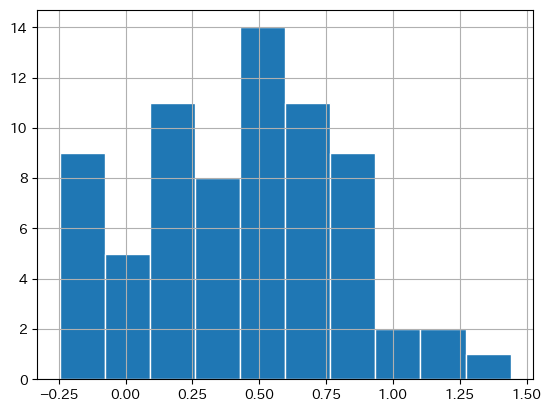

In [49]:
bigmac['price_yen_deviation'].hist(ec='white')
pass

`0.0`が日本となる。一番高い国を調べてみよう。

In [50]:
cond = ( bigmac['price_yen'] == bigmac['price_yen'].max() )
bigmac.loc[cond,['country','price_yen','price_yen_deviation']]

,country,price_yen,price_yen_deviation
,,,
1168,Switzerland,1098.15539,1.440345


In [51]:
from myst_nb import glue
cond = ( bigmac['price_yen'] == bigmac['price_yen'].max() )
bigmac_max_country = bigmac.loc[cond,'country'].iloc[0]
bigmac_max_price = bigmac.loc[cond,'price_yen'].iloc[0]
glue("bigmac_max_country_glued", bigmac_max_country)
glue("bigmac_max_price_glued", bigmac_max_price)

'Switzerland'

1098.1553902059181

{glue:text}`bigmac_max_country_glued`の価格は約{glue:text}`bigmac_max_price_glued:.0f`円となっている。次に，価格が最も低い国を表示してみよう。

In [52]:
cond = ( bigmac['price_yen']==bigmac['price_yen'].min() )
bigmac.loc[cond,['country','price_yen','price_yen_deviation']]

,country,price_yen,price_yen_deviation
,,,
1224,Taiwan,339.076894,-0.246496


In [53]:
from myst_nb import glue
cond = ( bigmac['price_yen']==bigmac['price_yen'].min() )
bigmac_min_country = bigmac.loc[cond,'country'].iloc[0]
bigmac_min_deviation = -100*bigmac.loc[cond,'price_yen_deviation'].iloc[0]
glue("bigmac_min_country_glued", bigmac_min_country)
glue("bigmac_min_deviation_glued", bigmac_min_deviation)

'Taiwan'

24.64957917680938

{glue:text}`bigmac_min_country_glued`が一番安く，日本より約{glue:text}`bigmac_min_deviation_glued:.1f`％も安価である。

明らかにBig Macの一物一価は成立していない。

価格のばらつき具合を確認し，上で確認した国内財の価格と比較するために，変動係数（平均からの乖離の標準偏差と同じ）を計算しよう。

In [54]:
bigmac['price_yen'].std() / bigmac['price_yen'].mean()

0.2630775659462129

In [55]:
from myst_nb import glue
bigmac_cv = bigmac['price_yen'].std() / bigmac['price_yen'].mean()
glue("bigmac_cv_glued", bigmac_cv)

0.2630775659462129

国内のチョコレート，アイスクリーム，ガソリン価格の標準偏差よりも非常に大きな値となっている。

理由として次のことが言えるだろう。
* Big Macは消耗財であり，貿易されずに生産された地域で消費される。言い換えると，消耗財が故に輸送費用は非常に高い非貿易財である。
* 非貿易財の場合，国境を超えた競争が妨げられる。神戸のマクドナルドは，ロンドンやシンガポールのマクドナルドと価格競争をしているとは言い難い。

### 所得の影響

価格が最も高い`15`カ国国をリストアップしてみよう。

In [56]:
bigmac_sorted = (
                 bigmac.sort_values('price_yen',ascending=False)
                    .loc[:,['country','price_yen','price_yen_deviation']]
)
bigmac_sorted.head(15)

,country,price_yen,price_yen_deviation
,,,
1168,Switzerland,1098.155390,1.440345
1207,Norway,983.106806,1.184682
1226,Uruguay,974.413346,1.165363
1180,Finland,932.067608,1.071261
1193,Italy,908.570106,1.019045
1160,Argentina,851.628372,0.892507
1174,Germany,836.511097,0.858914
1206,Netherlands,834.944597,0.855432
1181,France,830.245096,0.844989


```{admonition} コードの説明
:class: dropdown
丸括弧`()`の中にコードを書く場合，任意の箇所で改行してもエラーにはならない。1行で長いコードを書く場合に便利なので覚えておこう！
```

全て所得が高い先進国となっている。価格が最も安い`10`カ国を確認してみよう。

In [57]:
bigmac_sorted.tail(10)

,country,price_yen,price_yen_deviation
,,,
1185,Hong Kong,419.023683,-0.068836
1204,Malaysia,414.360612,-0.079199
1225,Ukraine,403.948396,-0.102337
1212,Philippines,400.954028,-0.108991
1230,South Africa,398.666873,-0.114074
1228,Venezuela,386.278992,-0.141602
1176,Egypt,372.141633,-0.173019
1190,India,361.035298,-0.197699
1189,Indonesia,358.026525,-0.204385


貧しい国が並んでいる。実は，この結果は偶然ではない。Big Macの価格と所得の散布図を使い相関関係を確かめてみるために，円表示の一人当たりGDPを計算しよう。新たな列`gdppc_yen`を作成する

In [58]:
bigmac['gdppc_yen'] = ( bigmac['gdppc_local']/bigmac['exr'] )*ejp

散布図をプロットしよう。

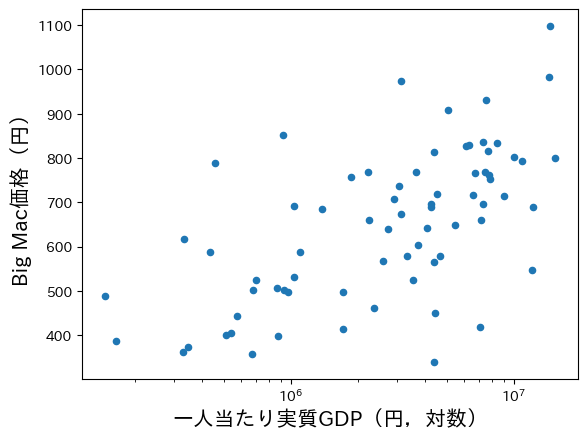

In [59]:
ax = bigmac.plot('gdppc_yen', 'price_yen', kind='scatter', logx=True)
ax.set_xlabel('一人当たり実質GDP（円，対数）', fontsize=15)
ax.set_ylabel('Big Mac価格（円）', fontsize=15)
pass

```{admonition} コードの説明
:class: dropdown
１行目の`logx=True`は，横軸の変数`gdppc_yen`を対数化することを指定している。もし縦軸も対数化したければ`logy=True`を使うと良いだろう。これらの引数を使うことにより，対数化した変数を`bigmac`に追加することなく図示できる。便利なので覚えておこう！
```

明らかに所得が高い国ではBig Macの価格は高くなっている。理由は，市場為替レートを使い円に変換していることに起因する。この現象の経済学的な含意については後ほど議論することにする。

```{note}
価格水準と所得の正の関係は経済間だけではなく，国内のデータでも観測されている。[Cheung and Fujii (2014)](https://academic.oup.com/oep/article-abstract/66/4/1070/2912951)は日本のデータを使い，都道府県の価格と所得の間に正の相関があることを報告している。
```

## 購買力平価と物価水準の分布

### PPPとは

前節の分析から分かったことは，市場為替レートで各国のBig Macの価格を共通貨幣単位（上の例では円）で表し価格を比べてみると，一物一価は成立していないということである。また，国内財と比較して分布の幅は大きいことも確認できた。今度は逆に，Big Macの一物一価が成立する場合の交換レートはどのように定義されるかを考えてみよう。

$$
\frac{P_i}{e_{i}^{\text{BM}}}=P_{\text{US}}
$$ (eq:19-a)

$e_{i}^{\text{BM}}$がBig Macの一物一価レートであり，単位は「$i$国通貨/米ドル」である。左辺では$e_{i}^{\text{BM}}$により$i$国通貨表示の価格$P_i$が米ドルに換算され，右辺の$P_{\text{US}}$と等価となっている。この式を書き換えると

$$
e_{i}^{\text{BM}}=\frac{P_i}{P_{\text{US}}}
$$ (eq:19-aa)

となる。

Big Macだけではなく財・サービスの種類を大幅に広げて，上述の考えを適用したのが購買力平価（PPP, Purchasing Power Parity）レートである。それぞれの経済で消費される同じような典型的な共通の財・サービスを集めて大きなバスケット（大きな籠）に入れることを想像しよう。多くの財・サービスが入ったバスケットを１つの財（合成財）として考え，バスケット財と呼ぶことにしよう。バスケット財に含まれる様々な財の価格は各経済で異なることになり，その結果，バスケット財の価格も異なる。バスケット財には多種多様の財・サービスが含まれているため，その価格を各国の一般物価水準と考えることができる。購買力平価（PPP）レートとは，バスケット財が等価となる為替レートとして算出される。次式は$i$国の対米国PPPレートである。

$$
\varepsilon_i=\frac{P_i}{P_{\text{US}}}
$$ (eq:19-20)

* $P_i$：$i$国の自国通貨価格で表した一般物価水準（バスケット財の価格）
* $P_{\text{US}}$：米国の自国通貨価格（米ドル）で表した一般物価水準（バスケット財の価格）
* $\varepsilon_i$：$i$国のPPPレート（$i$国通貨/米ドル）

式[](eq:19-20)について４つ説明を加える。
1. 右辺の単位は$i$国の通貨/ドルとなり，$e_i^{\text{BM}}$と同じ単位である。実際，$\varepsilon_i$は為替レートの一種であり，市場為替レートと異なるため特別な呼称「購買力平価レート」が付いている。
1. 上の式は$P_i/\varepsilon_i=P_{\text{US}}$と書くことができる。この式の右辺は米国のバスケット財の価格，即ち，一般物価水準であり，左辺は$i$国のバスケット財，即ち，一般物価水準を米ドルに換算した価格である。等号は，それらが等しいことを意味しており，その意味では，バスケット財の一物一価が成立する場合の為替レートということになる。まとめると，PPPレートは次のように解釈することができる。
    > 購買力平価レート$\varepsilon_i$は，バスケット財の一物一価が成立する（一般物価水準が同じになる）ために必要な為替レート（注意：バスケット財に含まれる個々の財・サービスの価格が全て等しいとは限らない。）
1. 次の変数を考えよう。
    * $Q_i$と$Q_{\text{US}}$：$i$国と米国でのバスケット財の数量
    * $P_i$と$P_{\text{US}}$：$i$国と米国でのバスケット財の価格
    * $M_i$：$i$国の自国通貨の数量
    * $M_{\text{US}}$：米ドルの数量
    
    それぞれの通貨はバスケット財の支出に使われる場合を考えると次の関係になる。
    
    $$
    M_i=P_iQ_i,\qquad M_{\text{US}}=P_{\text{US}}Q_{\text{US}}
    $$ (eq:19-ppp0)
    
    またバスケット財で測ったそれぞれの通貨の購買力は次式で表される。

    $$
    \frac{M_i}{P_i}=Q_i,\qquad \frac{M_{\text{US}}}{P_{\text{US}}}=Q_{\text{US}}
    $$ (eq:19-ppp1)
    
    それぞれの通貨の購買力が等しくなる場合，$Q_i=Q_{\text{US}}$が成立する。即ち，
    
    $$
    \frac{M_i}{P_i}=\frac{M_{\text{US}}}{P_{\text{US}}}
    \qquad\Rightarrow\qquad
    \frac{M_i}{M_{\text{US}}}=\frac{P_i}{P_{\text{US}}}
    $$ (eq:19-ppp2)
    
    となる。右の式の左辺は，１米ドルと$i$国通貨の交換レート（単位は$i$国通貨/１米ドル）を表している。それを$\varepsilon_i$と置き換えるとPPPレート
    
    $$
    \varepsilon_i=\frac{P_i}{P_{\text{US}}}
    $$ (eq:19-ppp3)
    
    となる。このことから次のように解釈できる。
    > 購買力平価レート$\varepsilon_i$は２つの通貨の購買力を等しくする交換レート
        
1. 実質為替レートは次式で与えられる。

    $$
    \eta_i=\frac{e_iP_{\text{US}}}{P_i}=\frac{e_i}{\varepsilon_i}
    $$ (eq:19-rexr)

    ここで$\varepsilon_i$は式[](eq:19-20)で与えられるPPPレートであり，$e_i$は市場為替レートである。更に，

    $$
    \eta_i=1
    \quad\Leftrightarrow\quad
    e_i=\varepsilon_i
    $$ (eq:19-rexrA)
    
    が成立することになる。即ち，実質為替レートが`1`の場合に$e_i=\varepsilon_i$となり，「購買力平価が成立した」という。

```{note}
PPPレートは次のようにも解釈できる。式[](eq:19-rexr)と[](eq:19-rexr)から，PPPの下では次式が成立する。

$$
1=\frac{P_i/\varepsilon_i}{P_{\text{US}}}
$$ (eq:19-21)

分子の$P_i$の単位は「$i$国の通貨」であり，$\varepsilon_i$の単位は「$i$国の通貨/ドル」となるため，分子の単位はドルとなることが分かる（$i$国の通貨単位がキャンセルされる）。分母の単位はもちろん米ドルである。更に，次のように書き換えよう。

$$
1=\frac{1万ドル/P_{\text{US}}}{1万ドル/(P_i/\varepsilon_i)}
$$ (eq:19-22)

分子は1万ドルで米国のバスケット財をいくつ購入できるかを表しており，それが米ドルの購買力である。同様に，分母は1万ドルで購入できる$i$国のバスケット財の数量を表し，$i$国のバスケット財で測った米ドルの購買力となる。即ち，右辺は1万ドルの米国での購買力と$i$国での購買力の割合となる。右辺が`1`と等しいということは，1万ドルの米国での購買力と$i$国での購買力は同じだということを意味する。
```

以上の説明から，一物一価の法則と購買力平価が密接に関係していることは直感的に理解できるだろう。以下では，バスケット財の価格は経済間で大きく異なり，購買力平価は成立していないことを示す。更には，その原因と含意についても考察することにする。

### PPPレートと市場為替レートのデータ

#### 使用するデータ

経済間のバスケット財の価格の違いを確認するために，`py4macro`モジュールに含まれるPenn World Tableのデータセットを使う。

In [60]:
pwt = py4macro.data('pwt')

変数の定義を確認しておこう。

In [61]:
py4macro.data('pwt', description=True)

,Variable definition
,
Identifier variables,NaN
countrycode,3-letter ISO country code
country,Country name
currency_unit,Currency unit
year,Year
"Real GDP, employment and population levels",NaN
rgdpe,Expenditure-side real GDP at chained PPPs (in mil. 2017US$)
rgdpo,Output-side real GDP at chained PPPs (in mil. 2017US$)
pop,Population (in millions)


以下の分析では次の変数を使う。
* `xr`：市場為替レート（名目，$i$国通貨/米ドル）
* `pl_gdpo`：`cgdpo`の計算に使った相対物価水準（米ドル，2017年の米国の値=`1`）
* `cgdpo`：産出データに基づいGDP（2017年百万米ドル）
    * 時系列的には名目（ある年での経済間の生産能力（水準）の比較に適している）
    * `pl_gdpo`を使って計算している

```{note}
`cgdpo`は産出データに基づいたGDPだが，その代わりに支出データに基づいた`cgdpe`を使うこともできる。その場合，相対物価水準の変数には`pl_da`を使う必要がある。試してみよう！
```

`pwt`の中にはPPPレートのデータは含まれていないが，`xr`と`pl_gdpo`を使い次のように計算することができる。`pl_gdpo`は次式に従い計算されている。

$$
\text{(列 pl_gdpo)}=\frac{\epsilon_i}{e_i}
=\frac{P_i}{P_{\text{US}}e_i}
$$ (eq:19-30)

ここで$\epsilon_i$は式[](eq:19-20)で与えられるPPPレートであり，$e_i$は市場為替レートとなる。従って，$e_i$に列`xr`を使い次式でPPPレートを計算することができる。

$$
\epsilon_i=\text{(列 pl_gdpo)}\times\text{(列 xr)}
$$ (eq:19-31)

この式に従って，新たな列`ppp`を`pwt`に追加しよう。

In [62]:
pwt['ppp'] = pwt['pl_gdpo'] * pwt['xr']

#### 例：日本

まず，PPPレートと市場為替レートがどれほど違うかを日本の時系列データで確認するために，日本のデータのみを抽出する。日本のPPPと市場為替レートをプロットしてみよう。

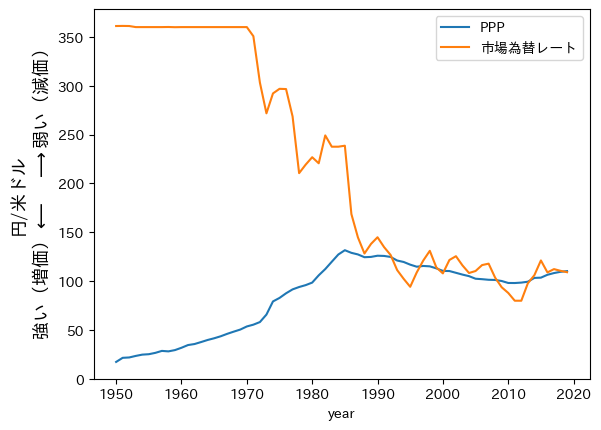

In [63]:
cond = ( pwt['countrycode']=='JPN' )
ax = pwt.loc[cond,:].plot(x='year', y=['ppp','xr'], label=['PPP','市場為替レート'])
ax.set_ylabel('円/米ドル\n'+
              r'強い（増価）$\longleftarrow\quad\longrightarrow$弱い（減価）', fontsize=13)
pass

```{note}
上のプロットの縦軸は円/米ドルであり，値が低く（高く）なると円は強く（弱く）なる。増価，減価とも表現される。分かりにくいようであれば，次のように考えてみてはどうだろう。
* 為替レートが100円/ドルということは，100円で１ドルを買うことができる。
* 為替レートが80円/ドルの場合は，80円で１ドルを買うことができる。即ち，より安くドルを買うことができるので，円の購買力は高くなる。そういう意味で，円は強くなった（増価した）と言える。
* 為替レートが120円/ドルの場合は，120円で１ドルを買うことになる。即ち，より高い価格でドルを買うことになるので，円の購買力は低下している。そういう意味で，円は弱くなった（減価した）と言える。
```

このプロットから次のことが言える。市場為替レートは1973年2月14日に変動相場制へ移行するまで360円/１米ドルで固定されていた。1980年代半ば頃までは，PPPレートと比べて市場為替レートは高い値となっている。従って，PPPレートを基準とすると円はドルに対して弱すぎる，即ち，過小評価されていたことが分かる。長期的にはPPPレートと為替レートは収斂したことが確認できる。しかし，1980年代半ば以降，市場為替レートはPPPレートの周りを上下していおり，ある程度の乖離は解消されていない。

このように，PPPレートと市場為替レートは乖離することが常であり，異なる要因によって決定されるためである。PPPは式[](eq:19-20)が示すように財・サービスの価格の比率であり，一般物価水準そしてその変化率（インフレ率）も持続性が高い（粘着生）ためPPPの動きは緩やかである。一方，市場為替レートは貨幣単位の比率であり，国際収支の状況にも大きく依存する。国際収支には（１）経常収支（財・サービスの収支など），（２）資本移転等収支（例えば，特許権などの知的財産権），（３）金融収支（直接投資，証券投資，金融派生商品など金融資産に伴う取引）があるが，特に（２）と（３）は一般物価水準との関係は少なくとも短期的には弱い。従って，市場為替レートは経済情報や政治状況，更には，中央銀行総裁や政治家の発言で影響を受け大きく瞬時に変動することがある。しかし，上の日本のレートのプロットが示すように，長期的には乖離が持続的に拡大するような発散は起きていない。1980年代半ばまでの時系列データが示すように，お互いに時間をかけて収束する経済メカニズムが裏で働いていると考えられる。

上のプロットではPPPレートと市場為替レートを別々にプロットしたが，一つの指標としてまとめる方が分かりやすい場合もある。式[](eq:19-rexr)を使い日本の実質為替レート$\eta_{\text{JP}}$を考えてみよ。

$$
\eta_{\text{JP}}
=\frac{e_{\text{JP}}P_{\text{US}}}{P_{\text{JP}}}
=\frac{e_{\text{JP}}}{\varepsilon_{\text{JP}}}
$$ (eq:19-23)

ここで$e_{\text{JP}}$は市場為替レート（円/米ドル）であり，$\varepsilon_{\text{JP}}$はPPPレートである。この式から次のことが分かる。
* $\eta_{\text{JP}}=1\quad\Rightarrow\quad e_{\text{JP}}=\varepsilon_{\text{JP}}$
    * 購買力平価の成立
    * 日本のバスケット財１単位で米国のバスケット財１単位を購入できる（等価で交換できる）。
* $\eta_{\text{JP}}<1\quad\Rightarrow\quad e_{\text{JP}}<\varepsilon_{\text{JP}}$
    * PPPレートと比較しては強すぎる（過大評価）
    * 例えば，$\eta_{\text{JP}}=1/2$の場合，日本のバスケット財１単位で米国のバスケット財２単位も購入できる（交換できる）。そういう意味で，円の購買力は高過ぎる（強過ぎる）。
* $\eta_{\text{JP}}>1\quad\Rightarrow\quad e_{\text{JP}}>\varepsilon_{\text{JP}}$
    * PPPレートと比較して円は弱すぎる（過小評価）
    * 例えば，$\eta_{\text{JP}}=2$の場合，日本のバスケット財１単位で米国のバスケット財１/２単位しか購入できない（交換できない）。そういう意味で，円の購買力は低過ぎる（弱過ぎる）

式[](eq:19-30)と[](eq:19-23)を比べると，$\eta_{\text{JP}}$は`pl_gdpo`の逆数となることがわかる。実質為替レートを新たな列`real_xr`として`pwt`に追加しよう。

In [64]:
pwt['real_xr'] = 1 / pwt['pl_gdpo']

1980年以降のデータをプロットしよう。

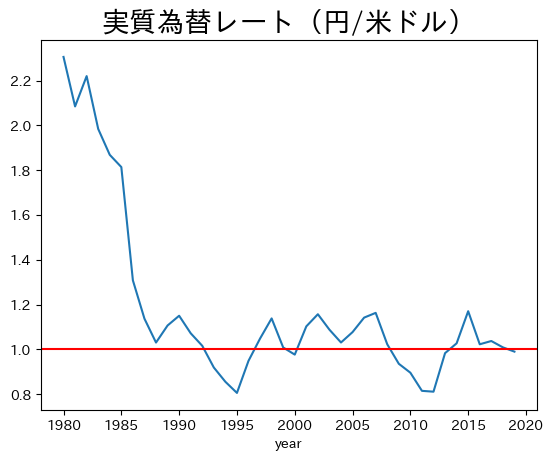

In [65]:
cond_jp = ( pwt['countrycode']=='JPN' )
cond_yr = ( pwt['year']>=1980 )
cond = cond_jp & cond_yr
ax = pwt.loc[cond,:].plot(x='year', y='real_xr', legend=False)
ax.axhline(1, color='red')
ax.set_title('実質為替レート（円/米ドル）', fontsize=20)
pass

この図は，上の図の情報を実質為替レート（円/ドル）としてまとめている。実質為替レートでも，縦軸での円安・円高の方向は同じとなることに注意しよう。1980年代半ばまで円高に動いていること（増価）が分かる。

```{note}
[国際通貨研究所では円（対米ドル）の購買力平価](https://www.iima.or.jp/research/ppp.html)を公表しているが，`pwt`のデータとは大きく異なる。理由は，それぞれの目的とアプローチが違うためである。Penn World Tableで使うPPPは，共通の財・サービスの分類に基づいた[国際比較プログラム](https://www.worldbank.org/en/programs/icp)（International Comparison Programme：省略ICP）により計算された情報を使っており，参加国（2017年には176カ国）のGDPや支出項目が比較可能になるPPPの算出を目的としている。従って，大掛かりな作業が必要であり，毎年ではなく数年に一度公表される（1970年, 1973年, 1975年, 1980年, 1985, 1993年, 2005年, 2011年, 2017年）。Penn World Tableのデータでは，それ以外の年は内挿（interpolate）もしくは外挿（extrapolate）することによりPPPを計算している。一方，国際通貨研究所で公表しているPPPは，1973年を基準としてシンプルに日米の消費者物価指数などを使って算出されており，指数の計算に使われる財・サービスは厳密に共通化されている訳ではない。後者は円ドル市場為替相場の予測や日本経済の国際競争力を知る上では有用な情報となるだろう。
```

### 相対一般物価水準の分布

Big Macは世界中で消費され，世界中のBig Macは概ね同質と考えることができる。そのような財でさえ一物一価が成立していないことを考えると，バスケット財の一物一価の成立を疑いたくなる。実際，以下で示すように，データは一般物価の等価は成立しない。では，
> バスケット財の価格（一般物価水準）はどのような分布になっているのだろうか。

この問を考察するために，米国を基準とする米ドル表示の相対一般物価水準考えることにする。相対価格で考える利点は，その分布をPPPレートと市場為替レートを使うことにより簡単に計算できることである。

式[](eq:19-30)から列`pl_gdpo`の定義は次のようになっている。

$$
\begin{align*}
\text{列 pl_gdpo}
&=
\frac{P_i/e_i}{P_{\text{US}}}=
\frac{i\text{国のバスケット財のドル価格}}{\text{米国のバスケット財のドル価格（2017年）}}\\
&=\text{米国（2017年）を基準とした}i\text{国のバスケット財の相対価格（一般物価水準の比率）}
\end{align*}
$$ (eq:19-plgdpo)

相対一般物価水準の分布を調べるためには`pl_gdpo`を使えば良いということだ。まず2019年のデータを抽出して`pwt19`に割り当てよう。

In [66]:
cond = ( pwt['year']==2019 )
pwt19 = pwt.loc[cond,:].copy()

`pl_gdpo`が欠損値ではない国の数を確認しておこう。

In [67]:
pwt19['pl_gdpo'].notna().sum()

183

このデータを使い相対価格のヒストグラムをプロットするが，視覚的に確認し易いように対数化した列を作成し図示する。（試しに，対数を使う目的を理解するために`pl_gdpo`のヒストグラムと比べてみてはどうだろう。）

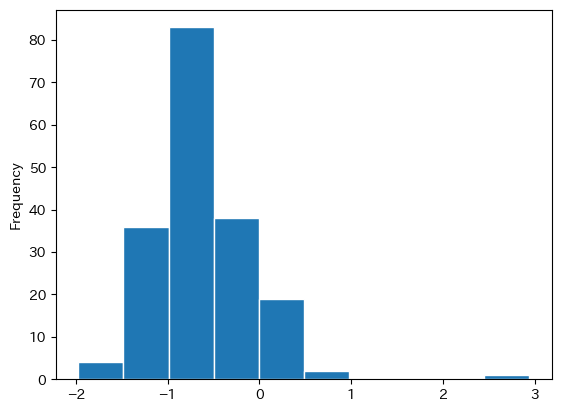

In [68]:
pwt19['pl_gdpo_log'] = np.log( pwt19['pl_gdpo'] )

pwt19['pl_gdpo_log'].plot(kind='hist', ec='white')
pass

次のような解釈となる。
* `0`と等しい場合：米国の2017年の物価水準と同じ
* `0`を上回る場合：米国の2017年の物価水準を上回る
* `0`を下回る場合：米国の2017年の物価水準を下回る

その内訳を確認してみよう。

In [69]:
cond = ( pwt19['pl_gdpo_log']>=0 )
print(f'相対一般物価水準が１以上の国の数：{pwt19.loc[cond,:].shape[0]:>3}')
print(f'相対一般物価水準が１未満の国の数：{pwt19.loc[~cond,:].shape[0]:>3}')

相対一般物価水準が１以上の国の数： 22
相対一般物価水準が１未満の国の数：161


```{admonition} コードの説明
:class: dropdown
最後の行に`~cond`となっているが，`~`はビット演算子の一つである。`cond`は`True`もしくは`False`が要素となる`Series`であるが，`~`を`cond`の前に付けると全ての真偽値を反転（`True`は`False`に，`False`は`True`に）させる。ビット演算子には他に`&`，`|`，`^`，などがある。
```

一般物価水準の相対価格の分布には大きな偏りが確認できる。`pl_gdpo`（対数ではない）の記述統計を表示してみよう。

In [70]:
pwt19['pl_gdpo'].describe()

count    183.000000
mean       0.691109
std        1.385720
min        0.139218
25%        0.395466
50%        0.490066
75%        0.741123
max       18.842592
Name: pl_gdpo, dtype: float64

In [71]:
from myst_nb import glue
pwt19_describe = pwt19['pl_gdpo'].describe()
pwt19_price_min = 100*pwt19_describe['min']
pwt19_price_max = pwt19_describe['max']
glue("pwt19_price_min_glued", pwt19_price_min)
glue("pwt19_price_max_glued", pwt19_price_max)

13.9218270778656

18.842592239379883

価格水準が最も低い国は米国（2017年）の物価水準の約{glue:text}`pwt19_price_min_glued:.1f`％しかなく，最も高い国は米国（2017年）の約{glue:text}`pwt19_price_max_glued:.1f`倍も高い。上位5カ国を表示してみよう。

In [72]:
pwt19.sort_values('pl_gdpo',ascending=False)[['country','pl_gdpo']].head()

,country,pl_gdpo
12389,Venezuela (Bolivarian Republic of),18.842592
1609,Bermuda,2.309026
11199,Turks and Caicos Islands,1.894385
209,Anguilla,1.572530
3079,Cayman Islands,1.491452


ベネズエラの`pl_gdpo`の値は突出している。[ベネズエラの2018年のインフレは1,700,000％（年率）のハイパーインフレ](https://en.wikipedia.org/wiki/Hyperinflation_in_Venezuela)が発生しており，その影響かもしれないが，他の経済の傾向と大きく異なる「外れ値」の可能性を払拭できない。以下ではベネズエラを除外して分析を進めることにする。

In [73]:
cond = ~( pwt19['countrycode']=='VEN' )
pwt19 = pwt19.loc[cond,:].copy()

ベネズエラを除いたデータで`pl_gdpo`の変動係数を計算してみよう。

In [74]:
pwt19['pl_gdpo'].std() / pwt19['pl_gdpo'].mean()

0.5361108623656162

この値をBig Macの値と比べてみよう。Big Macの変動係数は{glue:text}`bigmac_cv_glued:.3f`であり，`0.3`にも満たない。バスケット財に含まれる財・サービスはBig Mac程規格が統一されていないことを考えると一般物価水準の変動係数が大きいことは理解できるのではないだろうか。

````{note}
上で計算したBig Mac価格の変動係数は，相対価格ではなくBig Mac価格（円表示）の変動係数である。米国のBig Mac価格に対する相対価格の変動係数を次のコードで計算することができるが，同じ値を返すことになる。
```
bigmac['price_dollar'] = bigmac['price_local'] / bigmac['exr']
cond = ( bigmac['iso']=='USA' )
bigmac['relative_price_dollar'] = bigmac['price_dollar'] / bigmac.loc[cond,'price_dollar'].iloc[0]
bigmac['relative_price_dollar'].std() /bigmac['relative_price_dollar'].mean()
```
````

## 物価水準に対する所得の影響

### 所得の影響

相対物価水準のヒストグラムをプロットしたが，どのような国がどのような順番並んでいるか表示してみよう。表示するリストを見やすくするために，183カ国全てを表示せずに，行`avh`（人的資本ストック）に欠損値がない国だけを表示しよう。このルールに特別な意味はないが，国の数を減らすには丁度良いだろう。

```{admonition} コードの説明
:class: dropdown
* `#1`：`.dropna(subset=['avh`])`を使い列`avh`に欠損値がある行のみを削除し，`.sort_values('pl_gdpo_log')`によって`pl_gdpo_log`の昇順に並び替えた`DataFrame`を`pwt19_dropped`に割り当てている。
* `#2`：`.stem()`はステムプロットを表示するメソッドであり，横軸に列`country`，縦軸に`pl_gdpo_log`を指定している。
* `#3`：`orientation`はステムプロットの向きを横向きに指定する引数。この引数により，縦軸・横軸が逆になる。
* `#4`：`bottom`は値の基準を指定する引数。ここでは`0`に赤い線が引かれる。
* `#5`：`data`は使用するデータを指定する。
* `#6`：横軸の値範囲を指定している。
* `#7`：`.axhline()`は横線を表示するメソッド。`Japan`は縦軸の`Japan`で横線を引くことを指定し，`linestyle=':'`は点線を
指定している。
* `#8`：`pwt19_dropped.shape[0]`で`pwt19_dropped`の行数を抽出し，`f-string`を使い`結果を表示している。
```

このプロットには66カ国が含まれる。


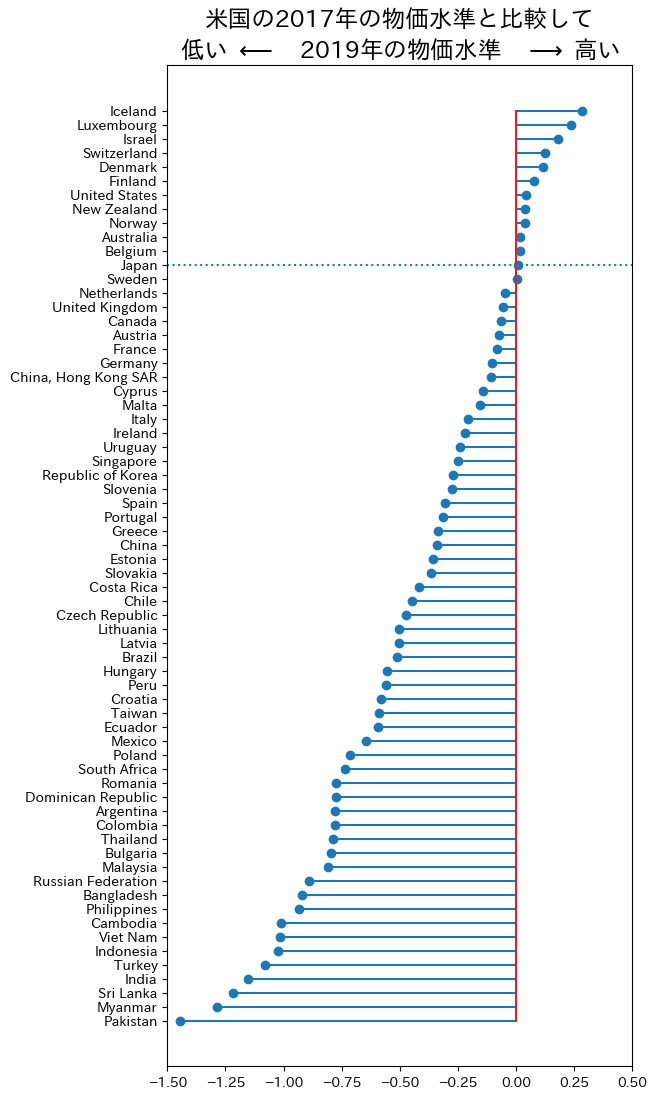

In [75]:
#1
pwt19_dropped = pwt19.dropna(subset=['avh']).sort_values('pl_gdpo_log')

fig, ax = plt.subplots(figsize=(6,13))
ax.stem('country', 'pl_gdpo_log',      #2
        orientation='horizontal',      #3
        bottom=0,                      #4
        data=pwt19_dropped)            #5
ax.set_xlim(-1.5,0.5)                  #6
ax.set_title('米国の2017年の物価水準と比較して\n'+
             r'低い $\longleftarrow\quad$2019年の物価水準$\quad\longrightarrow$ 高い',
             size=17)
ax.axhline('Japan', linestyle=':')     #7

#8
print(f'このプロットには{pwt19_dropped.shape[0]}カ国が含まれる。')

リストの上には所得が高い国が列挙されており，所得が低い国はリストの下の方にある。この傾向はBig Macの場合と同じである。

物価水準と所得の関係を散布図を使って確認するために，一人当たりGDPとその対数値を新たな列`cgdpo_pc`と`cgdpo_pc_log`を追加しよう。

In [76]:
pwt19['cgdpo_pc'] = pwt19['cgdpo']/pwt19['pop']
pwt19['cgdpo_pc_log'] = np.log( pwt19['cgdpo_pc'] )

また`pl_gdpo`の対数の値を新たな列`pl_gdpo_log`として追加しよう。

In [77]:
pwt19['pl_gdpo_log'] = np.log( pwt19['pl_gdpo'] )

`cgdpo_pc_log`を横軸にして`pl_gdpo_log`の散布図を表示しよう。

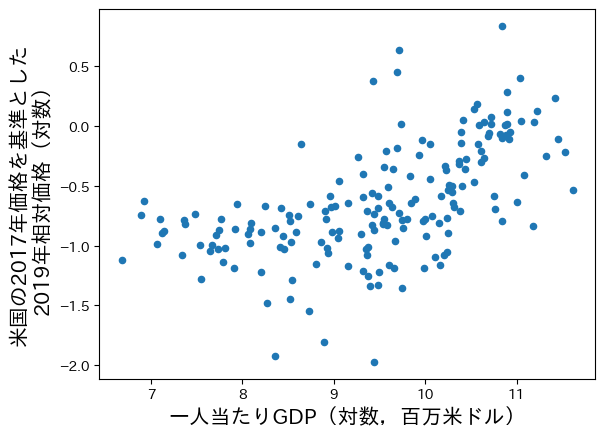

In [78]:
ax = pwt19.plot('cgdpo_pc_log', 'pl_gdpo_log', kind='scatter')
ax.set_xlabel('一人当たりGDP（対数，百万米ドル）', fontsize=15)
ax.set_ylabel('米国の2017年価格を基準とした\n2019年相対価格（対数）', fontsize=15)
pass

直線トレンドを想像してみよう。明らかに右上がりであり，所得が高い経済ほど物価水準が高いことが確認できる。これは**バラッサ・サミュエルソン効果**と呼ばれる。直感的には，所得が高い経済の生産性と価格は高く，多くが貿易財である。一方，所得が低い国の非貿易財（例えば，不動産）やサービス（例えば，散髪）は比較的に安い。右上がりの直線トレンドはそれらの反映と考えられる。

しかし，非線形のトレンドを想像するとどうだろう。U字のトレンドを描くことができないだろうか。所得が高い経済では右上がりとなるが，所得が低い経済では逆に緩やかな右下がりとなり，U字の底が一人当たりGDP（対数）が`8.8`辺りだろうか。この場合，バラッサ・サミュエルソン効果は所得が比較的高い経済では強く現れるが，所得が低い経済では弱いと解釈できる。

このような非線形の相関を考慮して，次節では所得の効果の推定をおこなうことにする。

### 所得効果の分離

ここで考える問題は
> 1. 所得効果を他の影響からどのように分離することができるだろうか。
> 2. 所得効果は価格の散らばりの何％を説明できるだろうか。

ここでは，まず問題１について考える。相対価格の決定要因は次式に従って分解できると仮定しよう。

$$
p_i= D_i^{\text{所得}}D_i^{\text{その他}}\\
$$ (eq:19-9)

* $p_i\equiv\dfrac{P_{i}/e_i}{P_{\text{US}}}$：相対価格
* $D_i^{\text{所得}}$：所得効果の部分
* $D_i^{\text{その他}}$：所得以外の要因によって決まる部分

２つの項については次の仮定を置く。

$$
D_i^{\text{所得}}=x_i^{b+c\log(x_i)},
\qquad
D_i^{\text{その他}}=e^{a+u_i}
$$ (eq:19-11)

* $x_i=\dfrac{i\text{国の一人当たりGDP（米ドル）}}{\text{米国の一人当たりGDP（米ドル）}}$
* $b$：所得効果の強さを捉えるパラメーター
* $c$：所得効果の非線形の効果を捉えるパラメーター
* $a$：その他の要因によって決定される定数
* $u_i$：その他のランダムな要因（誤差項）

（注意） $D_i^{\text{所得}}$の右辺にある$x_i$の指数は$b+c\log(x_i)$となっているが，$c\log(x_i)$が上述のU字型の相関関係を捉える項となる。

式[](eq:19-9)に対数を取ると次式となる。

$$
\log\left(p_i\right)=d_i^{\text{所得}}+d_i^{\text{その他}}
$$ (eq:19-10)

* $d_i^{\text{所得}}\equiv\log\left(D_i^{\text{所得}}\right)
=\left[b+c\log\left(x_i\right)\right]\log\left(x_i\right)
=b\log(x_i)+c\left[\log\left(x_i\right)\right]^2$
* $d_i^{\text{その他}}\equiv\log\left(D_i^{\text{その他}}\right)=a+u_i$

式[](eq:19-10)を回帰式として次のようにまとめることができる。

$$
\log\left(p_i\right)=a+b\log\left(x_i\right)+c\left[\log\left(x_i\right)\right]^2+u_i
$$ (eq:19-12)

式[](eq:19-12)をOLS推定し，$\hat{a}$，$\hat{b}$，$\hat{c}$をパラメーターの推定値，$\hat{u}_i$を残差とすると，次式が成立する。

$$
\log\left(p_i\right)=\hat{a}+\hat{b}\log\left(x_i\right)
+\hat{c}\left[\log\left(x_i\right)\right]^2+\hat{u}_i
$$ (eq:19-13)

これらの推定値を使い，次のように$\log\left(p_i\right)$を２つの要因にに分解することができる。

$$
\log\left(p_i\right)=
\hat{d}_i^{\text{所得}}
+\hat{d}_i^{\text{その他}}
$$ (eq:19-14)

ここで
* $\hat{d}_i^{\text{所得}}=\hat{b}\log\left(x_i\right)+\hat{c}\left[\log\left(x_i\right)\right]^2$
* $\hat{d}_i^{\text{その他}}=\hat{a}+\hat{u}_i$

以下では$\hat{d}_i^{\text{所得}}$と$\hat{d}_i^{\text{その他}}$を計算し，それぞれの要因によって発生する相対価格の対数$\log\left(p_i\right)$のばらつき具合（具体的には，分散）を確認することにする。

```{note}
なぜ$\hat{a}$は$\hat{D}_i^{\text{その他}}$に含まれるか考えてみよう。式[](eq:19-12)の代わりに次の定数項のみの推定式を使って$a$を推定したとしよう。

$$
\log\left(p_i\right)=a+u_i
$$

[Pythonで学ぶ計量経済学](https://py4etrics.github.io/13_Dummies.html)で説明しているように，この場合の推定値$\overline{a}$は$\log\left(y_i\right)$の平均と等しい。ここで重要な点は，$\overline{a}$は所得効果を含んだ$y_i$の平均値だということである。一方，推定式[](eq:19-12)には$x_i$が入っているため，定数項の推定値$\hat{a}$は，所得効果を取り除いた後の$y_i$の平均値という解釈が成り立つ。この考え方に従うと，$\log\left(y_i\right)$の平均値$\overline{a}$は次の２つに分解することができる。
* $\overline{a}-\hat{a}$：$y_i$の平均値における所得効果の部分
* $\hat{a}$：$y_i$の平均値におけるその他の部分

この解釈に基づき，$\hat{a}$は$\hat{D}_i^{\text{その他}}$に含めている。
```

### 推定

OLSを使って式[](eq:19-12)を推定するが，まず$\log\left(x_i\right)$と$[\log\left(x_i\right)]^2$の変数に使う値を作成する。

In [79]:
cond = ( pwt19['countrycode']=='USA' )
pwt19['cgdpo_pc_ratio_log'] = ( pwt19['cgdpo_pc_log'] -
                                pwt19.loc[cond,'cgdpo_pc_log'].iloc[0] )
pwt19['cgdpo_pc_ratio_log_2'] = pwt19['cgdpo_pc_ratio_log']**2

この２変数を使い回帰式を推定する。

In [80]:
formula = 'pl_gdpo_log ~ cgdpo_pc_ratio_log + cgdpo_pc_ratio_log_2'
res = smf.ols(formula, data=pwt19).fit()
print(res.summary(slim=True))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:            pl_gdpo_log   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.384
No. Observations:                 182   F-statistic:                     57.32
Covariance Type:            nonrobust   Prob (F-statistic):           5.76e-20
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.1121      0.059     -1.889      0.060      -0.229       0.005
cgdpo_pc_ratio_log       0.5386      0.073      7.346      0.000       0.394       0.683

$\hat{b}$と$\hat{c}$の統計的な優位性は非常に高い。また$\hat{c}>0$はU字型のトレンドを示している。

データの散布図に回帰線を重ねて表示して当てはまり具合を視覚的に確認してみることにしよう。式[](eq:19-9)から予測値は

$$
\log\left(\hat{p}_i\right)=\hat{a}+\hat{b}\log\left(x_i\right)
+\hat{c}\left[\log\left(x_i\right)\right]^2
$$

となる。この式を使い，予測値の値を新たな列として`pwt19`に追加しよう。

In [81]:
# パラメーターの推定値
ahat = res.params.iloc[0]
bhat = res.params.iloc[1]
chat = res.params.iloc[2]

# 予測値
pwt19['fitted'] = ( ahat+
                    bhat*pwt19['cgdpo_pc_ratio_log']+
                    chat*pwt19['cgdpo_pc_ratio_log_2']
                  )

プロットしてみよう。

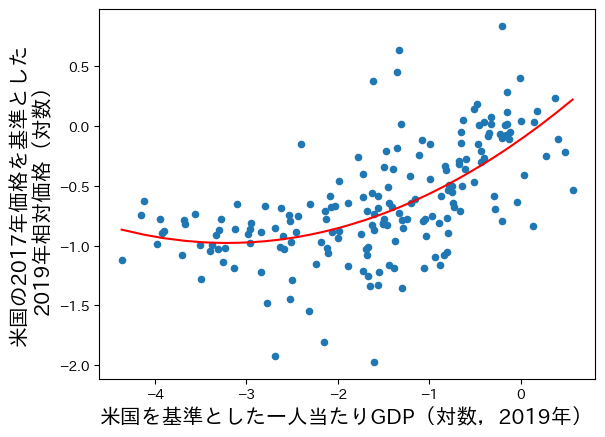

In [82]:
# 散布図
ax = pwt19.plot('cgdpo_pc_ratio_log', 'pl_gdpo_log', kind='scatter')
ax.set_xlabel('米国を基準とした一人当たりGDP（対数，2019年）', fontsize=15)
ax.set_ylabel('米国の2017年価格を基準とした\n2019年相対価格（対数）', fontsize=15)

# 回帰曲線
ax.plot('cgdpo_pc_ratio_log', 'fitted', color='red',
        data=pwt19.sort_values('cgdpo_pc_ratio_log'))  #1
pass

```{admonition} コードの説明
:class: dropdown
`#1`の`pwt19.sort_values('cgdpo_pc_ratio_log'))`は，列`cgdpo_pc_ratio_log`の値に従って`pwt19`を昇順に並び替えている。これによりスムーズな回帰曲線を表示できるようになる。並び替えないとどうなるか試してみよう。
```

### ヒストグラムの比較

式[](eq:19-14)にある３つの項$\log\left(p_i\right)$，$\hat{d}_i^{\text{所得}}$，$\hat{d}_i^{\text{その他}}$のヒストグラムを比較してみよう。まず，$\hat{d}_i^{\text{所得}}$と$\hat{d}_i^{\text{その他}}$の定義に基づいて`pwt19`に新たな列を作成しよう。

In [83]:
# 所得の影響
pwt19['income_effect'] = ( bhat*pwt19['cgdpo_pc_ratio_log']+
                           chat*pwt19['cgdpo_pc_ratio_log_2']
                         )

# 所得以外の効果
pwt19['other_effect'] = ahat+res.resid

３つの変数のヒストグラムを並べて表示する。

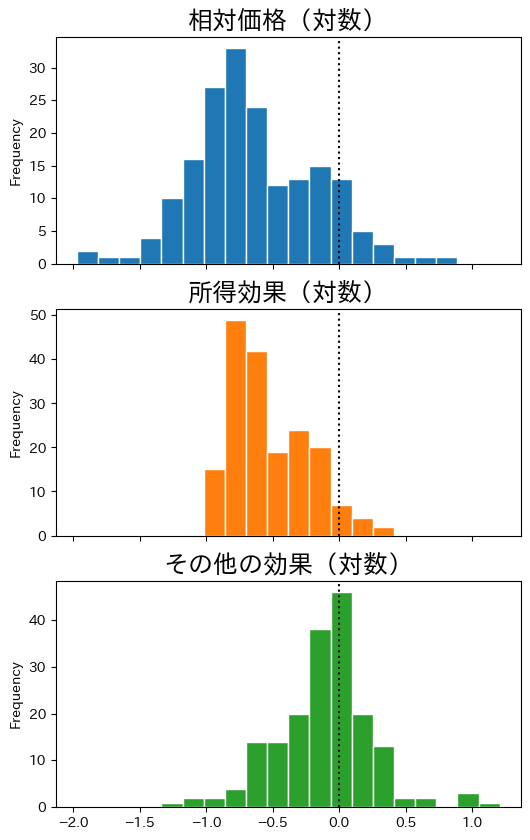

In [84]:
col_lst = ['pl_gdpo_log','income_effect','other_effect']
title_lst = ['相対価格（対数）','所得効果（対数）','その他の効果（対数）']

ax = pwt19[col_lst].plot(kind='hist',
                         bins=20,
                         ec='white',
                         subplots=True,
                         legend=False,
                         figsize=(6,10))

for i, s in enumerate(title_lst):
    ax[i].set_title(s, fontsize=18)
    ax[i].axvline(0, color='k', linestyle=':')
pass

`0.0`（縦の点線）で$\dfrac{P_i/e_i}{P_{\text{US}}}=1$となることに注意しよう。次のことが言える。
* 所得とその他の効果を足し合わせることで一番上の相対価格の分布となる。言い換えると，相対価格の分布から所得効果を取り除くことにより一番下のその他の効果となる。
* 所得効果の分布の最頻値は負の値となっており，米国の物価水準より低い経済において所得効果が大きいということを意味する。
* その他の効果は`0.0`を中心に分布している。若干，相対価格が低い階級に国の数が多いように見える。

### 所得効果の大きさ

ここでは次の問いを考察する。
> 相対価格のばらつきの何割が所得効果に起因するのだろうか。

$y_i=\log\left(p_i\right)$として式[](eq:19-9)を再掲する。

$$
y_i= d_i^{\text{所得}}+ d_i^{\text{その他}}\\
$$ (eq:19-15)

この式の両辺の分散を次のように計算することにより，所得効果の割合を計算することが可能となる。まず，$p_i$の分散を$d_i^{\text{所得}}$と$d_i^{\text{その他}}$の分散に分解しよう。

$$
\begin{align*}
\text{Var}(y_i)
&=\text{Var}\left(\hat{d}_i^{\text{所得}}+\hat{d}_i^{\text{その他}}\right)\\
&=\text{Var}\left(\hat{d}_i^{\text{所得}}\right)+
    \text{Var}\left(\hat{d}_i^{\text{その他}}\right)+
    2\text{Cov}\left(\hat{d}_i^{\text{所得}},\hat{d}_i^{\text{その他}}\right)\\
&=\underbrace{
    \text{Var}\left(\hat{d}_i^{\text{所得}}\right)+
    \text{Cov}\left(\hat{d}_i^{\text{所得}},\hat{d}_i^{\text{その他}}\right)
    }_{\text{所得効果}}+
  \underbrace{
    \text{Var}\left(\hat{d}_i^{\text{その他}}\right)+
    \text{Cov}\left(\hat{d}_i^{\text{所得}},\hat{d}_i^{\text{その他}}\right)
    }_{\text{その他の効果}}
\end{align*}
$$ (eq:19-16)

上の計算では，$d_i^{\text{所得}}$と$d_i^{\text{その他}}$の共分散が存在するため，それを所得とその他に等分している。

更に，この結果を次のように書き直すことができる（[「回帰分析」の章](sec:6-regression-da)を参照）。

$$
\begin{align*}
\left(
\begin{split}
&\text{所得効果}\\
&\text{の割合}
\end{split}
\right)
&=\frac{
      \text{Var}\left(\hat{d}_i^{\text{所得}}\right)+
    \text{Cov}\left(\hat{d}_i^{\text{所得}},\hat{d}_i^{\text{その他}}\right)
    }{
    \text{Var}(y_i)}
=\frac{
    \text{Cov}\left(y_i,\hat{d}_i^{\text{所得}}\right)
    }{
    \text{Var}(y_i)}
\end{align*}
$$ (eq:19-17)

$$
\begin{align*}
\left(
\begin{split}
&\text{その他の効果}\\
&\text{の割合}
\end{split}
\right)
&=\frac{
      \text{Var}\left(\hat{d}_i^{\text{その他}}\right)+
    \text{Cov}\left(\hat{d}_i^{\text{所得}},\hat{d}_i^{\text{その他}}\right)
    }{
    \text{Var}(y_i)}
=\frac{
    \text{Cov}\left(y_i,\hat{d}_i^{\text{その他}}\right)
    }{
    \text{Var}(y_i)}
\end{align*}
$$ (eq:19-18)

この式に従って計算してみよう。

In [85]:
# 所得効果の割合
income = pwt19[['pl_gdpo_log','income_effect']]
income.cov().iloc[0,1] / income.cov().iloc[0,0]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0.39041607482876517

In [86]:
from myst_nb import glue
income = pwt19[['pl_gdpo_log','income_effect']]
income_effect = 100*income.cov().iloc[0,1] / income.cov().iloc[0,0]
glue("income_effect_glued", income_effect)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


39.041607482876515

In [87]:
# 所得以外の効果の割合
other = pwt19[['pl_gdpo_log','other_effect']]
other.cov().iloc[0,1] / other.cov().iloc[0,0]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0.6095839251712347

分散の割合で考えた場合，所得効果は全体の約{glue:text}`income_effect_glued:.0f`％を占めている。一般物価水準の一物一価が成立しない大きな理由が所得の差ということが明らかになった。一方で，所得以外の要因も大きな影響を及ぼしている。「その他」の要因は大きく２つに分けることができる。
* 財・サービスの貿易（国際収支における貿易・サービス収支に該当）
    * 国境をまたぐ国際貿易での輸送費用は非常に大きく，一物一価の大きな妨げとなっている。
    * Big Macのように非貿易財（例えば，教育，建設，不動産，政府サービス）も存在する。輸送費用は著しく大きいため，貿易されない財と考えることができる。非貿易財の存在は経済間の一物一価の妨げとなっている。
    * 一般物価水準を説明する上でバスケット財という合成財を考えた。しかし，全ての国で全く同じ財がある訳ではない。また，一般物価水準を計算する上で，各国の支出データを使いウェイトを算出し加重平均を計算することになるが，経済によって支出割合は異なるためウェイトも異なることになる。
* 経済間の金融取引（国際収支における金融収支などに該当）
    * 経済間では財・サービスだけではなく金融資本の取引がおこなわれる。例えば，直接投資，証券投資，金融派生商品などである。長期的な投資だけではなく，短期的な投資や投機も含まれるため，資金が瞬時に動くことになり市場為替レートが大きな影響を受けることになる。

````{note}
式[](eq:19-17)は次のように書き直すことも可能である。

```{math}
:label: eq:19-19
\begin{align*}
\left(
\begin{split}
&\text{所得効果}\\
&\text{の割合}
\end{split}
\right)
&=\frac{
    \text{Cov}\left(y_i,\hat{d}_i^{\text{所得}}\right)
    }{
    \text{Var}(y_i)}
=\frac{
    \text{Cov}\left(y_i-\hat{u}_i+\hat{u}_i,\hat{b}x_i+\hat{a}-\hat{a}\right)
    }{
    \text{Var}(y_i)}\\
&=\frac{
    \text{Cov}\left(\hat{p}_i+\hat{u}_i,\hat{y}_i-\hat{a}\right)
    }{
    \text{Var}(y_i)}\\
&=\frac{
    \text{Cov}\left(\hat{y}_i,\hat{y}_i\right)
    -\text{Cov}\left(\hat{y}_i,\hat{a}\right)
    +\text{Cov}\left(\hat{u}_i,\hat{y}_i\right)
    -\text{Cov}\left(\hat{u}_i,\hat{a}\right)
    }{
    \text{Var}(y_i)}\\
&=\frac{
    \text{Cov}(\hat{y}_i,\hat{y}_i)
    }{
    \text{Var}(y_i)}
=\frac{
    \text{Var}(\hat{y}_i)
    }{
    \text{Var}(y_i)}
=R^2\;\text{（決定係数）}
\end{align*}
```
回帰分析の結果が含まれる`res`を使って確認してみよう。
```
res.rsquared
```
上で計算した所得効果の割合と等しいことが確認できるはずだ。
````

## 所得効果の含意

### PPPレートと市場為替レート：再考

上の分析で一般物価水準が経済によって大きく異なることを示すために，式[](eq:19-plgdpo)を使った。その式を式[](eq:19-30)と[](eq:19-rexr)を使って次のように表すことができる。

$$
\begin{align*}
\text{(列 pl_gdpo)}
&=
\frac{P_i/e_i}{P_{\text{US}}}\\
&=\text{米国（2017年）を基準とした}i\text{国のバスケット財の相対価格}\\
&=\frac{1}{\eta_i}=\frac{\varepsilon_i}{e_i}
\end{align*}
$$ (eq:19-plgdpoA)

即ち，相対一般物価水準はPPPレートと市場為替レートに分解することができるということであり，経済間での相対一般物価水準の違いは，PPPレートと市場為替レートの乖離として現れるということである。この点を踏まえると，次のことが分かる。
* `pl_gdpo`$=1$：$\varepsilon_{i}=e_{i}$
    * $i$国の物価水準は米国と同じ場合，PPPレートと市場為替レートは同じ。
* `pl_gdpo`$>1$：$\varepsilon_{i}>e_{i}$
    * $i$国の物価水準は米国よりも高い場合，PPPレートと比較して$i$国の通貨は強すぎる。
* `pl_gdpo`$<1$：$\varepsilon_{i}<e_{i}$
    * $i$国の物価水準は米国よりも低い場合，PPPレートと比較して$i$国の通貨は弱すぎる。

更に，相対一般物価水準の違いは所得水準の違いに大きな影響を受けることが明らかになったが，式[](eq:19-plgdpoA)によると，所得効果はPPPレートと市場為替レートの乖離にも大きな影響を与えることが分かる。次のようにまとめることができる。
> 所得が高い経済の通貨は強く，所得が低い経済の通貨は弱い傾向となっている。

### ペン効果

PPPレートと市場為替レートの乖離は所得水準に影響されることが明らかになったが，その経済学的な含意は次のようにまとめることができる。

> 市場為替レートを使いGDPを評価すると，貧しい国の貧しさは誇張される。

これは**ペン効果**と呼ばれる。英語ではPenn Effectと呼ばれ，Pennは本章で使ったデータセットPenn World TableのPennから来ている。

ペン効果を簡単な数値例で説明するために，Big Macだけを生産する２国を考えてみよう。A国は豊かな経済であり，B国は貧しい経済としよう。A国は年間$Y_A=10$個のBig Mac，B国は$Y_B=5$個のBig Macを生産している。A国の貨幣単位は$\$_A$であり，B国の貨幣は$\$_B$とし，価格は$P_A=\$_A10$，$P_B=\$_B10$としよう。それぞれの自国通貨で評価すると，A国のGDPは$10\times\$_A10=\$_A100$であり，A国のGDPは$5\times\$_B10=\$_B50$である。

この場合，PPPレートは

$$
\varepsilon_{B/A}=\frac{P_B}{P_A}=\frac{10}{10}=1
\quad\text{（単位：$\$_B/\$_A$）}
$$ (eq:19-b00)

となる。まず，一物一価が成立したとしよう。この場合，市場為替レートを$e_{B/A}$（単位：$\$_B/\$_A$）とすると，$\varepsilon_{B/A}=e_{B/A}=1$が成立することになり，A国の通貨$\$_A$で表した相対価格は

$$
\frac{P_B/e_{B/A}}{P_A}=\frac{10/1}{10}=1
$$ (eq:19-b2)

となる。購買力平価が成立する場合のGDPの比率は次のようになる。

$$
\frac{Y_BP_B/e_{B/A}}{Y_AP_A}=\frac{5\times10/1}{10\times10}=\frac{50}{100}=\frac{1}{2}
$$ (eq:19-b3)

B国のGDPはA国の半分ということだ。

次に，ペン効果を導入する。所得の影響により為替レートは$e_{B/A}=2$と仮定しよう。即ち，B国は比較的に貧しいため，B国の通貨は弱いという仮定である。この場合，A国の通貨$\$_A$で表した相対価格は

$$
\frac{P_B/e_{B/A}}{P_A}=\frac{10/2}{10}=\frac{5}{10}=\frac{1}{2}<1
$$ (eq:19-b0)

となり，A国の価格がB国よりも高く一物一価は成立しない。上述のデータと合致したパターン（豊かな国の価格が高い）となっている。相対的なGDPを計算してみよう。

$$
\frac{Y_BP_B/e_{B/A}}{Y_AP_A}=\frac{5\times10/2}{10\times10}=\frac{25}{100}=\frac{1}{4}
$$ (eq:19-b1)

B国のGDPはA国の25％しかない。所得効果がない購買力平価が成立する場合の50％と対照的であり，ペン効果により所得格差が誇張されている。

### 一人当たりGDPの分布

上の数値例をデータを使って確認してみよう。ここでは`pwt19`を使い，PPPレートで計算された一人当たりGDPと市場為替レートに基づいた一人当たりGDPを計算し比較する。

変数`cgdpo_pc`はPPPレートで計算した一人当たりGDP（2017年米ドル）である。具体的に説明するために，次の変数を定義しよう。
* $Y_i$：$i$国の産出量
* $P_i$：$i$国の貨幣表示の物価水準
* $L_i$：$i$国の人口
* $\varepsilon_i$：１米ドル当たりの$i$国のPPPレート

`cgdpo_pc`は次のように計算されている。

$$
\text{(列 cgdpo_pc)}=\frac{P_iY_i/L_i}{\varepsilon_i}
$$ (eq:19-p0)

`pwt19`に市場為替レートのGDPを新たな列`cgdpo_pc_xr`として追加するとしよう。`cgdpo_pc`を使うと次の計算となる。

$$
\text{(列 cgdpo_pc_xr)}
=\frac{P_iY_i/L_i}{\varepsilon_i}\times\frac{\varepsilon_i}{e_i}
=\text{(列 cgdpo_pc)}\times\frac{\text{(列 ppp)}}{\text{(列 xr)}}
$$ (eq:19-p0A)

列`cgdpo_pc_xr`を追加する。

In [88]:
pwt19['cgdpo_pc_xr'] = pwt19['cgdpo_pc'] * pwt19['ppp'] / pwt19['xr']

対数値も作成しておこう。

In [89]:
pwt19['cgdpo_pc_xr_log'] = np.log( pwt19['cgdpo_pc_xr'] )

まず散布図を使ってペン効果を確かめてみる。

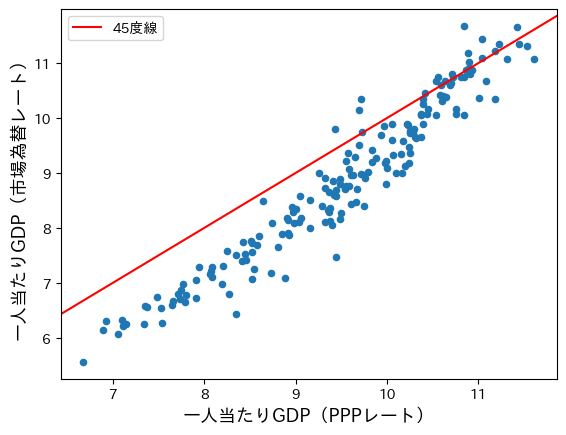

In [90]:
ax = pwt19.plot('cgdpo_pc_log','cgdpo_pc_xr_log', kind='scatter')
ax.axline((9, 9), (10, 10), color='red', label='45度線')  #1
ax.set_xlabel('一人当たりGDP（PPPレート）', fontsize=13)
ax.set_ylabel('一人当たりGDP（市場為替レート）', fontsize=13)
ax.legend()
pass

```{admonition} コードの説明
:class: dropdown
* `#1`：`.axline()`は直線を表示するメソッドであり，引数で指定された座標２つを通過する直線がプロットされる。`(9,9)`は横軸`9`と縦軸`9`の座標であり，`(10,10)`は横軸`10`と縦軸`10`の座標となる。
```

横軸はPPPレートで計算した一人当たりGDPであり，縦軸には市場為替レートに基づく一人当たりGDPとなっている。それぞれのレートで計算した一人当たりGDPが等しければ45度線（赤線）上に観測値は並んでいるはずである。しかし，観測値は45度線よりも下に位置する傾向があり，特に所得が低い経済においては顕著である。即ち，市場為替レートを使い計算した一人当たりGDPは低く算出される傾向にあり，所得が低い経済においてその傾向は強い。

一人当たりGDPの分布を図示するためにカーネル密度推定をプロットしよう。（直感的には，カーネル密度推定とはヒストグラムの情報を使い，そのサンプルを生成した連続的な分布を推定する方法と考えれば良いだろう。）

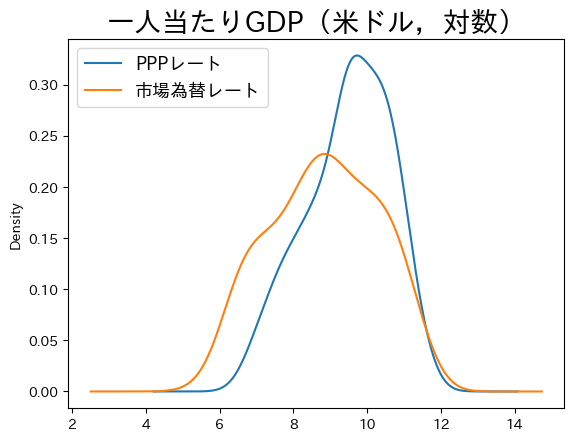

In [91]:
ax = pwt19[['cgdpo_pc_log','cgdpo_pc_xr_log']].plot(kind='kde')
ax.legend(['PPPレート','市場為替レート'], fontsize=13)
ax.set_title('一人当たりGDP（米ドル，対数）', fontsize=20)
pass

PPPレートGDPと比べて市場為替レートGDPは全体的に左（小さい値）にシフトしている。所得が中程度の国が減少し，所得が低い国が増加している。

記述統計を比べてみよう。

In [92]:
#1
stats_ppp = pwt19['cgdpo_pc_log'].describe().to_frame('PPPレートGDP')
stats_xr = pwt19['cgdpo_pc_xr_log'].describe().to_frame('市場為替レートGDP')

pd.concat([stats_xr,stats_ppp], axis='columns')  #2

,市場為替レートGDP,PPPレートGDP
count,182.000000,182.000000
mean,8.837957,9.479314
std,1.459575,1.137809
min,5.562148,6.678289
25%,7.733357,8.665637
50%,8.898444,9.585708
75%,10.056103,10.372745
max,11.676471,11.611350


```{admonition} コードの説明
:class: dropdown
* `#1`：`.describe()`は記述統計を`Series`として返すメソッド。`to_frame('PPPレートGDP')`は`Series`を`DataFrame`に変換するメソッドであり，引数'PPPレートGDP'を列ラベルに使う。
* `#2`：`pd.concat()`は`Pandas`の`DataFrame`を結合する関数。
    * 引数`[stats_xr,stats_ppp]`は結合する`DataFrame`をリストとして指定する。
    * `axis='columns'`は各`DataFrame`を列として結合することを指定している。
    * （注意）`pd.concat()`は行ラベルが合っているかはチェックしない。上のコードでは，行ラベルが同じだと分かっているので問題ないが，行ラベルが異なる`DataFrame`を結合する場合は`pd.merge()`を使うことを勧める。
```

上の結果をまとめると次のようになる。市場為替レートを使うことにより，
* GDPの平均，最小値，25％分位数，中央値，75％分位数は減少している。
* GDPの標準偏差と最大値は増加している。

これらは市場為替レートにより経済間の不平等が大きく計測されていることを示唆する。不平等の一つに変動係数（Coefficient of Variation）があるが（式[](eq:19-cc)を参照），それを使って比較してみよ。

変動係数が大きければ，所得不平等は大きいことを意味する。

In [93]:
cc_ppp = pwt19['cgdpo_pc_log'].std()/pwt19['cgdpo_pc_log'].mean()
cc_xr = pwt19['cgdpo_pc_xr_log'].std()/pwt19['cgdpo_pc_xr_log'].mean()

print('--- GDPの変動係数 ---')
print(f'PPPレート：{cc_ppp:>8.3f}')
print(f'市場為替レート：{cc_xr:.3f}')

--- GDPの変動係数 ---
PPPレート：   0.120
市場為替レート：0.165


市場為替レートに含まれる所得の影響がペン効果として現れていることが確認できる。

## まとめ

* 国内市場で財・サービスの一物一価は成立していない。
* 経済間でBig Macの価格の一物一価は成立していない。
* 経済間で一般物価水準は異なる。
* 購買力平価レートは２つの通貨の購買力を等しくする交換レート。
* 所得が高い（低い）経済の一般物価水準は高い（低い）傾向にある（所得効果）。
* 所得効果により，所得が低い経済の通貨は購買力平価レートと比べて弱い傾向にある。
* 市場為替レートを使い共通通貨で一人当たりGDPを比較すると，所得が低い経済の貧しさは誇張される。